# Age and Experience Plots

In [1051]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase

# path ro TEMP folder
temp_folder = os.path.join(os.getcwd(), '..', 'TEMP')
# Data folder
data_folder = os.path.join(os.getcwd(), '..', 'data')
# Image folder
img_folder = os.path.join(os.getcwd(), '..', 'images')
# Logo folder
logo_folder = os.path.join(os.getcwd(), '..', 'images', 'logos')


################################################################################
roster_file = os.path.join(data_folder, 'roster_2024_current_v2.csv') # PATH TO THE ROSTER FILE
roster_df = pd.read_csv(roster_file) # read as dataframe

# Path to school info table (csv)
school_info_file = os.path.join(data_folder, 'arena_school_info.csv')
school_info_df = pd.read_csv(school_info_file)

# print(roster_df.columns)

### Dictionaries and Constants

In [1052]:
## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart', 'St Lawrence']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

# Create a dictionary of {Team: logo_abv} for each team with .png added to the end
logo_mapping = {}

for index, row in school_info_df.iterrows():
    logo_mapping[row['Team']] = row['logo_abv'] + '.png'

# print(logo_mapping)

### Data Modifications

In [1053]:
# Convert DOB to datetime
roster_df['DOB'] = pd.to_datetime(roster_df['DOB'], errors='coerce')

# Calculate Player age from DOB (Using season start Oct 1, 2024)
roster_df['Age'] = (pd.Timestamp('2024-10-01') - roster_df['DOB']).apply(lambda x: x.days / 365.25)

# Rename Current Team to Team
roster_df.rename(columns={'Current Team': 'Team'}, inplace=True)

## Caclulate the average age of each team
team_avg_age = roster_df.groupby('Team')['Age'].mean().reset_index()


### Calculate Roster Makeup by Class 

In [1054]:
# Get a count of each class rank by team

# Create a pivot table of the class rank count
class_rank_count = roster_df.pivot_table(index='Team', columns='Yr', values='Last_Name', aggfunc='count', fill_value=0).reset_index()

# Calculate the total number of players on each team
class_rank_count['Total'] = class_rank_count['Fr'] + class_rank_count['So'] + class_rank_count['Jr'] + class_rank_count['Sr'] + class_rank_count['Gr']

# # Reorder the columns
# class_rank_count = class_rank_count[['Season', 'Current Team', 'Fr', 'So', 'Jr', 'Sr', 'Gr', 'Total']]
# # Convert the columns to int (0 for Nan)
# class_rank_count[['Fr', 'So', 'Jr', 'Sr', 'Gr', 'Total']] = class_rank_count[['Fr', 'So', 'Jr', 'Sr', 'Gr', 'Total']].fillna(0).astype(int)

## Add the average age to the class_rank_count
class_rank_count = class_rank_count.merge(team_avg_age, on='Team', how='left')


# Calculate the percentage of each class rank
class_rank_count['Fr%'] = class_rank_count['Fr'] / class_rank_count['Total']
class_rank_count['So%'] = class_rank_count['So'] / class_rank_count['Total']
class_rank_count['Jr%'] = class_rank_count['Jr'] / class_rank_count['Total']
class_rank_count['Sr%'] = class_rank_count['Sr'] / class_rank_count['Total']
class_rank_count['Gr%'] = class_rank_count['Gr'] / class_rank_count['Total']

# Reorder Columns
class_rank_count = class_rank_count[['Team', 'Age', 'Fr', 'Fr%', 'So', 'So%', 'Jr', 'Jr%', 'Sr', 'Sr%', 'Gr', 'Gr%', 'Total']]

# class_rank_count.tail(10)

In [1055]:
class_rank_count.head()

,Team,Age,Fr,Fr%,So,So%,Jr,Jr%,Sr,Sr%,Gr,Gr%,Total
0,Air Force,22.072724,12,0.375000,10,0.312500,4,0.125000,6,0.187500,0,0.000000,32
1,Alaska,22.676912,13,0.406250,4,0.125000,7,0.218750,5,0.156250,3,0.093750,32
2,Alaska Anchorage,22.503569,10,0.344828,6,0.206897,7,0.241379,4,0.137931,2,0.068966,29
3,American Intl,22.417434,8,0.242424,7,0.212121,8,0.242424,7,0.212121,3,0.090909,33
4,Arizona State,21.923431,6,0.193548,9,0.290323,5,0.161290,4,0.129032,7,0.225806,31


### Chart Style and Formatting Options

In [1056]:
# import matplotlib.font_manager as fm

# # Get the list of available fonts
# available_fonts = sorted([f.name for f in fm.fontManager.ttflist])

# # Display the list of fonts
# for font in available_fonts:
#     print(font)


In [1057]:
## Formatting constants
position_order = ['Forwards', 'Defensemen', 'Goaltenders'] # Set the order of the positions
class_order = ['Fr', 'So', 'Jr', 'Sr', 'Gr'] # Set the order of Class Rank

###### SETTINGS ######
zoom_factor = 0.25
y_offset = 1.1
age_offset = -.125
age_fontsize = 12
set_fig_size = '10, 10'

### Global Settings
set_linewidth = 1
all_color='lightgrey'




## FONT PARAMETERS
# font_path = 'C:/Windows/Fonts/Exo 2.tff'

font = "Roboto Slab"

font_title_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 16}
font_label_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 14}
font_tick_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 8}
font_label_large_param = {'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 16}
font_tick_large_param = {f'family': {font}, 'color': 'black', 'weight': 'normal', 'size': 12}

font_tag_parm = {f'family': 'CMU Sans Serif', 'color': 'black', 'weight': 'bold', 'size': 10}
font_tag_parm_2 = {f'family': {font}, 'color': 'black', 'weight': 'bold', 'size': 12}

### Functions

In [1058]:
### Add Team Logos to the Plot
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(10, 20), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")



In [1059]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

figure_size = (10, 10)

def plot_team_ages_and_experience_with_logos(df, team_names, region_name):
    """
    Plots a stacked bar chart comparing the age and experience of hockey teams, using team logos for x-axis labels.

    Parameters:
    - df: DataFrame containing team names, ages, and class proportions (Fr%, So%, Jr%, Sr%, Gr%).
    - team_names: List of the team names to be included in the plot.
    - region_name: The name of the region for the title of the plot.
    """
    
    # Filter the dataframe to include only the teams we want
    filtered_df = df[df['Team'].isin(team_names)]

    # Ensure team names match filtered dataframe
    valid_team_names = filtered_df['Team'].tolist()

    if len(valid_team_names) != len(team_names):
        print(f"Warning: Some teams in the input list are not in the dataframe. Using only valid teams: {valid_team_names}")
        team_names = valid_team_names
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Set the title of the plot
    ax.set_title(f"Age and Experience:\n{region_name}", fontsize=20, weight='bold', pad = 20)
    
    # Set y-axis label
    ax.set_ylabel("Proportion of Players", fontsize=16, weight='bold')
    
    # Ensure the y-axis represents 100%
    ax.set_ylim([0, 1])  # This makes sure the y-axis is scaled from 0 to 100%
    
    # Remove x-tick labels
    ax.set_xticks(range(len(team_names)))
    ax.set_xticklabels([])  # Remove the x-tick labels
    
    # Set gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Define year positions and corresponding colors for the stacked bars
    year_labels = ['Fr%', 'So%', 'Jr%', 'Sr%', 'Gr%']
    colors = ['#40A4D8', '#FDE725', '#FCA636', '#F94144', '#6A4C93']

    # Loop over each year label (Fr%, So%, Jr%, Sr%, Gr%) and plot the proportions
    bottom_values = [0] * len(team_names)
    for i, year in enumerate(year_labels):
        proportions = filtered_df[year].values
        
        # Plot the stacked bars for each class year
        bars = ax.bar(range(len(team_names)), proportions, bottom=bottom_values, color=colors[i], label=year)
        
        # Update bottom values to stack the next year's bars
        bottom_values = [x + y for x, y in zip(bottom_values, proportions)]
        
        # Add text annotations for each bar with bold font
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add text for non-zero heights
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.1%}',
                        ha='center', va='center', fontsize=12, weight='bold', color='black')
    

        # Now add the average age above each bar
    avg_ages = filtered_df['Age'].values
    for i, age in enumerate(avg_ages):
        # Position the average age text slightly above the tallest stacked bar
        ax.text(i, 1.015, f'{age:.2f}', ha='center', va='center', fontsize=12, 
        color='black', fontstyle = 'italic')

    # Add "Average Age" label just above the average age numbers
    fig.text(0.005, 0.915, "Average Age \n(years):", fontsize=14, ha='left', fontstyle = 'italic')

    # Remove y-axis ticks for cleaner look
    ax.set_yticks([])
    # Remover x-axis ticks
    ax.set_xticks([])
    
    # Adjust the logo scaling factor based on the number of teams
    zoom_factor = 0.1 + (0.75 / max(len(team_names), 10))  # Dynamic scaling based on team count
    y_offset = 1.15  # Adjust y-offset for logo placement
    age_offset = .95  # Adjust y-offset for age text placement
    age_fontsize = 10 + (30 / max(len(team_names), 10))  # Dynamic scaling for age text based on team count

    # Add team logos below the bars as x-tick labels
    for i, team in enumerate(team_names):
        if team in logo_mapping:
            file_path = os.path.join(logo_folder, logo_mapping[team])
            img = plt.imread(file_path)
            imagebox = OffsetImage(img, zoom=zoom_factor)
            # Adjust the positioning of logos below the x-axis
            ab = AnnotationBbox(imagebox, (i, 0), xycoords=('data', 'axes fraction'),
                                boxcoords="offset points", box_alignment=(0.5, y_offset), pad=0.1, frameon=False)
            ax.add_artist(ab)


        # # Retrieve and display the average age for each team
        # team_age = filtered_df.loc[filtered_df['Team'] == team, 'Age'].values[0]
        # team_age_text = f'AVG Age\n{team_age:.2f}'
        # ax.text(i, age_offset, team_age_text, ha='center', va='top', fontsize=age_fontsize, 
        #         weight='light', transform=ax.get_xaxis_transform())

    # Customize legend with full labels and specific location at the bottom
    handles, labels = ax.get_legend_handles_labels()

    # Map abbreviations to full words
    label_mapping = {
        'Fr%': 'Freshman',
        'So%': 'Sophomore',
        'Jr%': 'Junior',
        'Sr%': 'Senior',
        'Gr%': 'Graduate'
    }

    # Replace labels with full words
    labels = [label_mapping.get(label, label) for label in labels]

    # Create a legend with no reversal, positioned at the bottom
    ax.legend(handles, labels, title='', fontsize=14, loc='lower center', 
            ncol=len(labels), frameon=False, bbox_to_anchor=(0.5, -0.2))
    
    # Save the plot as PNG image
    plt.tight_layout()
    plt.savefig(f'{region_name}_age_experience_plot.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()


# Output

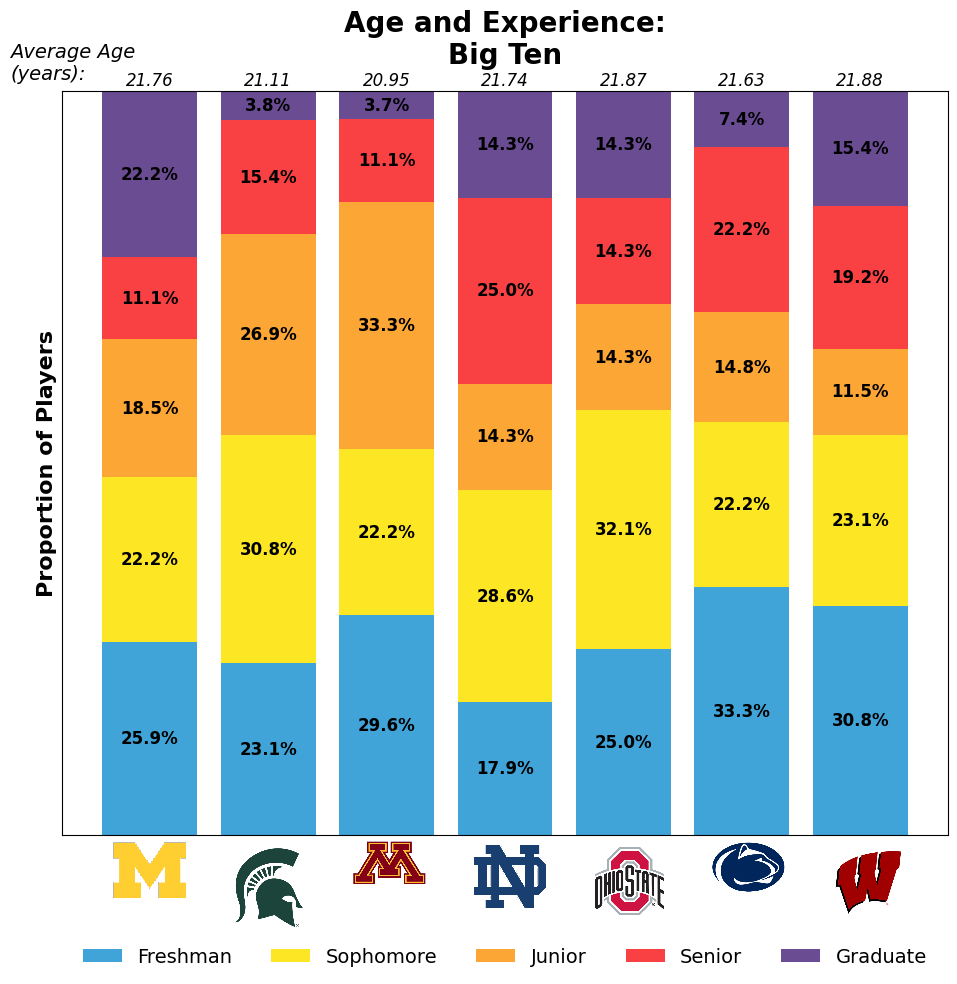

In [1060]:
## Call the function for atlantic region
plot_team_ages_and_experience_with_logos(class_rank_count, big_ten, 'Big Ten')

In [1061]:
# import matplotlib.pyplot as plt
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# import os

# figure_size = (10,10)

# def plot_team_ages_and_experience_with_logos(roster, team_names, region_name):
#     """
#     Plots a stacked bar chart comparing the age and experience of hockey teams, using team logos for x-axis labels.

#     Parameters:
#     - roster: DataFrame containing the team rosters.
#     - team_names: List of the team names to be included in the plot.
#     - region_name: The name of the region for the title of the plot.
#     - logo_mapping: Dictionary mapping team names to logo image filenames.
#     - logo_folder: Path to the folder containing the logo images.
#     - team_avg_age: DataFrame containing the average age for each team.
#     - figure_size: Tuple indicating the figure size.
#     """
    
#     # Filter the roster data to only include the teams in the specified region
#     region_roster = roster[roster['Team'].isin(team_names)]
    
#     # Create a figure and axis
#     fig, ax = plt.subplots(figsize=figure_size)
    
#     # Set the title of the plot
#     ax.set_title(f"{region_name} Teams: Age and Experience", fontsize=20, weight='bold')
    
#     # Set y-axis label
#     ax.set_ylabel("Proportion of Players (%)", fontsize=16)
    
#     # Ensure the y-axis represents 100%
#     ax.set_ylim([0, 1])  # This makes sure the y-axis is scaled from 0 to 100%
    
#     # Remove x-tick labels
#     ax.set_xticks(range(len(team_names)))
#     ax.set_xticklabels([])  # Remove the x-tick labels
    
#     # Set gridlines
#     ax.grid(axis='y', linestyle='--', alpha=0.6)
    
#     # Define year positions and corresponding colors for the stacked bars
#     year_labels = ['Fr', 'So', 'Jr', 'Sr', 'Gr']
#     colors = ['#40A4D8', '#FDE725', '#FCA636', '#F94144', '#6A4C93']

#     # Initialize bottom values for stacking bars
#     bottom_values = [0] * len(team_names)

#         # Loop over each year label (Fr, So, Jr, Sr, Gr) and calculate proportions
#     for i, year in enumerate(year_labels):
#         # Filter the data for each year (Freshman, Sophomore, etc.)
#         year_data = region_roster[region_roster['Yr'] == year]
        
#         # Calculate proportions for each class year (normalized counts)
#         class_proportions = year_data['Team'].value_counts(normalize=True).reindex(team_names).fillna(0)
        
#         # **Fix: Normalize class proportions to ensure they sum to 1 for each team**
#         total_proportions = class_proportions.sum()
#         if total_proportions > 0:  # Only normalize if there are values
#             class_proportions = class_proportions / total_proportions
        
#         # Plot the bar chart for this class year as proportions
#         bars = ax.bar(range(len(team_names)), class_proportions, bottom=bottom_values, color=colors[i], label=year)
        
#         # Update bottom values to stack the next year's bars
#         bottom_values = [x + y for x, y in zip(bottom_values, class_proportions)]
        
#         # Add text annotations for each bar with bold font
#         for bar in bars:
#             height = bar.get_height()
#             if height > 0:  # Only add text for non-zero heights
#                 ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.1%}',
#                         ha='center', va='center', fontsize=12, weight='bold', color='black')
    
#     # Remove y-axis ticks for cleaner look
#     ax.set_yticks([])
#     # Remover x-axis ticks
#     ax.set_xticks([])
    
#     # Adjust the logo scaling factor based on the number of teams
#     zoom_factor = 0.1 + (0.75 / max(len(team_names), 10))  # Dynamic scaling based on team count
#     y_offset = 1.15  # Adjust y-offset for logo placement
#     age_offset = .95  # Adjust y-offset for age text placement
#     age_fontsize = 10 + (30 / max(len(team_names), 10))  # Dynamic scaling for age text based on team count
#     # logo_offset = 1

#     # Add team logos below the bars as x-tick labels
#     for i, team in enumerate(team_names):
#         if team in logo_mapping:
#             file_path = os.path.join(logo_folder, logo_mapping[team])
#             img = plt.imread(file_path)
#             imagebox = OffsetImage(img, zoom=zoom_factor)
#             # Adjust the positioning of logos below the x-axis
#             ab = AnnotationBbox(imagebox, (i, 0), xycoords=('data', 'axes fraction'),
#                                 boxcoords="offset points", box_alignment=(0.5, y_offset), pad=0.1, frameon=False)
#             ax.add_artist(ab)


#         # Retrieve and display the average age for each team
#         if team in team_avg_age['Team'].values:
#             team_age = team_avg_age.loc[team_avg_age['Team'] == team, 'Age'].values[0]
#             team_age_text = f'AVG Age\n{team_age:.2f}'
#             ax.text(i, age_offset, team_age_text, ha='center', va='top', fontsize=age_fontsize, 
#                     weight='light', transform=ax.get_xaxis_transform())

#     # Customize legend with full labels and specific location at the bottom
#     handles, labels = ax.get_legend_handles_labels()

#     # Map abbreviations to full words
#     label_mapping = {
#         'Fr': 'Freshman',
#         'So': 'Sophomore',
#         'Jr': 'Junior',
#         'Sr': 'Senior',
#         'Gr': 'Graduate'
#     }

#     # Replace labels with full words
#     labels = [label_mapping.get(label, label) for label in labels]

#     # Create a legend with no reversal, positioned at the bottom
#     ax.legend(handles, labels, title='', fontsize=14, loc='lower center', 
#             ncol=len(labels), frameon=False, bbox_to_anchor=(0.5, -0.2))
    
#     # Save the plot as PNG image
#     plt.tight_layout()
#     plt.savefig(f'{region_name}_age_experience_plot.png', dpi=300, bbox_inches='tight')
    
#     # Show the plot
#     plt.show()


In [1062]:
# ## Call the Function for the Big Ten
# plot_team_ages_and_experience_with_logos(roster_df, big_ten, 'Big Ten')

In [1063]:
roster_df.head()
class_rank_count.head()

,Team,Age,Fr,Fr%,So,So%,Jr,Jr%,Sr,Sr%,Gr,Gr%,Total
0,Air Force,22.072724,12,0.375000,10,0.312500,4,0.125000,6,0.187500,0,0.000000,32
1,Alaska,22.676912,13,0.406250,4,0.125000,7,0.218750,5,0.156250,3,0.093750,32
2,Alaska Anchorage,22.503569,10,0.344828,6,0.206897,7,0.241379,4,0.137931,2,0.068966,29
3,American Intl,22.417434,8,0.242424,7,0.212121,8,0.242424,7,0.212121,3,0.090909,33
4,Arizona State,21.923431,6,0.193548,9,0.290323,5,0.161290,4,0.129032,7,0.225806,31
